In [ ]:
# default_exp trick_model

# trick_model

> Model with ResNet Trick for experiments.

# setup and imports

In [ ]:
# pip install git+https://github.com/ayasyrev/model_constructor

In [ ]:
# pip install git+https://github.com/kornia/kornia

In [ ]:
# export
from kornia.contrib import MaxBlurPool2d

In [ ]:
#export
from fastai.basic_train import *
from fastai.vision import *
from fastai.script import *
from model_constructor.net import *
from model_constructor.layers import SimpleSelfAttention, ConvLayer

In [ ]:
#export
import math
import torch
from torch.optim.optimizer import Optimizer, required
import itertools as it

In [ ]:
# export
from imagenette_experiments.train_utils import *

# New ResBlock

In [ ]:
# export
class NewResBlock(Module):
    def __init__(self, expansion, ni, nh, stride=1, 
                 conv_layer=ConvLayer, act_fn=act_fn,
                 pool=nn.AvgPool2d(2, ceil_mode=True), sa=False,sym=False, zero_bn=True):
        nf,ni = nh*expansion,ni*expansion
        self.reduce = noop if stride==1 else pool
        layers  = [(f"conv_0", conv_layer(ni, nh, 3, stride=stride, act_fn=act_fn)),
                   (f"conv_1", conv_layer(nh, nf, 3, zero_bn=zero_bn, act=False))
        ] if expansion == 1 else [
                   (f"conv_0",conv_layer(ni, nh, 1, act_fn=act_fn)),
                   (f"conv_1",conv_layer(nh, nh, 3, stride=1, act_fn=act_fn)), #!!!
                   (f"conv_2",conv_layer(nh, nf, 1, zero_bn=zero_bn, act=False))
        ]
        if sa: layers.append(('sa', SimpleSelfAttention(nf,ks=1,sym=sym)))
        self.convs = nn.Sequential(OrderedDict(layers))
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.merge =act_fn

    def forward(self, x): 
        o = self.reduce(x)
        return self.merge(self.convs(o) + self.idconv(o))

# Model Constructor

In [ ]:
# export
class Model(Net):
    def __init__(self):
        super().__init__()
        self.name = 'xresnet50_trick'
        self.c_out = 10
        self.expansion=4
        self.layers=[3, 4,  6, 3]
        self.stem_sizes = [3,32,64,64]
        self.act_fn= Mish()
        self.sa = True
        self.pool = MaxBlurPool2d(3, True)
        self.stem_pool = self.pool
        self.block = NewResBlock

In [ ]:
model = Model()

In [ ]:
model

 constr xresnet50_trick

In [ ]:
# model = xresnet50(c_out=10)

In [ ]:
# model.block = NewResBlock

In [ ]:
# pool = MaxBlurPool2d(3, True)

In [ ]:
# model.pool = pool
# model.stem_pool = pool

In [ ]:
# model.stem_sizes = [3,32,64,64]
# model.act_fn= Mish()
# model.sa = True

Mish activation loaded...


## repr model

In [ ]:
model()

Sequential(
  model xresnet50_trick
  (stem): Sequential(
    (conv_0): ConvLayer(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_1): ConvLayer(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (conv_2): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act_fn): Mish()
    )
    (stem_pool): MaxBlurPool2d()
  )
  (body): Sequential(
    (l_0): Sequential(
      (bl_0): NewResBlock(
        (convs): Sequential(
          (conv_0): ConvLayer(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), strid

In [ ]:
model.stem

Sequential(
  (conv_0): ConvLayer(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_1): ConvLayer(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (conv_2): ConvLayer(
    (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act_fn): Mish()
  )
  (stem_pool): MaxBlurPool2d()
)

In [ ]:
model.body

Sequential(
  (l_0): Sequential(
    (bl_0): NewResBlock(
      (convs): Sequential(
        (conv_0): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_1): ConvLayer(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act_fn): Mish()
        )
        (conv_2): ConvLayer(
          (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (idconv): ConvLayer(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [ ]:
model.head

Sequential(
  (pool): AdaptiveAvgPool2d(output_size=1)
  (flat): Flatten()
  (fc): Linear(in_features=2048, out_features=10, bias=True)
)

In [ ]:
# hide
model.body.l_0

Sequential(
  (bl_0): NewResBlock(
    (convs): Sequential(
      (conv_0): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_1): ConvLayer(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_2): ConvLayer(
        (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (conv): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (merge): Mish()
  )
  (bl_1): NewResBloc

In [ ]:
# hide
model.body.l_1

Sequential(
  (bl_0): NewResBlock(
    (reduce): MaxBlurPool2d()
    (convs): Sequential(
      (conv_0): ConvLayer(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_1): ConvLayer(
        (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_2): ConvLayer(
        (conv): Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (conv): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (m

In [ ]:
# hide
model.body.l_2

Sequential(
  (bl_0): NewResBlock(
    (reduce): MaxBlurPool2d()
    (convs): Sequential(
      (conv_0): ConvLayer(
        (conv): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_1): ConvLayer(
        (conv): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_2): ConvLayer(
        (conv): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (conv): Conv2d(512, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  

In [ ]:
# hide
model.body.l_3

Sequential(
  (bl_0): NewResBlock(
    (reduce): MaxBlurPool2d()
    (convs): Sequential(
      (conv_0): ConvLayer(
        (conv): Conv2d(1024, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_1): ConvLayer(
        (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_fn): Mish()
      )
      (conv_2): ConvLayer(
        (conv): Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (idconv): ConvLayer(
      (conv): Conv2d(1024, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )


# Lr find

In [ ]:
lr = 0.004
epochs = 5
moms = (0.95,0.95)
start_pct = 0.72
size=192
bs=32

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


In [ ]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time


set state called
LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


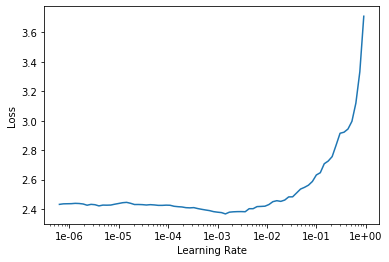

In [ ]:
learn.recorder.plot()

# epochs 5

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.883918,1.846014,0.397048,0.863578,01:41
1,1.637819,1.539176,0.553321,0.931535,01:42
2,1.510644,1.372857,0.630440,0.949351,01:42
3,1.338016,1.240664,0.696106,0.961059,01:43
4,1.128819,1.081582,0.775261,0.973785,01:43


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.881575,1.715641,0.478748,0.897684,01:42
1,1.649201,1.612771,0.522016,0.921863,01:43
2,1.435847,1.408255,0.603970,0.953423,01:43
3,1.332485,1.264232,0.690252,0.960804,01:43
4,1.081814,1.054678,0.787478,0.974803,01:43


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.881541,1.745737,0.442861,0.885467,01:43
1,1.663644,1.489441,0.568847,0.931789,01:43
2,1.448644,1.365747,0.622805,0.951387,01:43
3,1.338737,1.275746,0.675744,0.960804,01:43
4,1.115495,1.072398,0.777806,0.981166,01:43


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.850715,1.693888,0.464749,0.911682,01:43
1,1.601742,1.619644,0.509544,0.928735,01:42
2,1.470380,1.382942,0.631967,0.941461,01:43
3,1.327628,1.232158,0.687961,0.960550,01:43
4,1.125890,1.075535,0.774243,0.973530,01:43


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /root/.fastai/data/imagewoof2
Learn path /root/.fastai/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.868453,1.698171,0.462459,0.912446,01:43
1,1.637789,1.499534,0.575210,0.936371,01:43
2,1.477311,1.315345,0.654620,0.954696,01:43
3,1.347784,1.251300,0.690761,0.959532,01:43
4,1.110121,1.065618,0.778061,0.974294,01:43


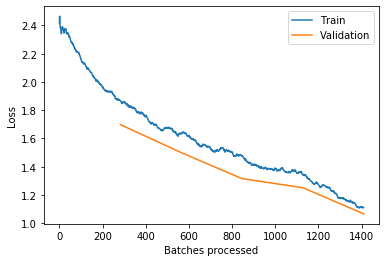

In [ ]:
learn.recorder.plot_losses()

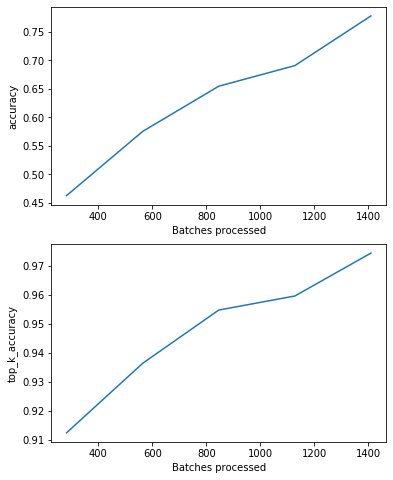

In [ ]:
learn.recorder.plot_metrics()

# e5 results

In [ ]:
acc = np.array([0.776533, 0.779588, 0.770171, 0.791041, 0.776279])

In [ ]:
acc.mean(), acc.std()

(0.7787224, 0.00687586048724083)

# epochs 20

In [ ]:
epochs = 20

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.889153,1.805073,0.420209,0.862306,01:41
1,1.660659,1.538020,0.554849,0.919318,01:42
2,1.512285,1.405557,0.608297,0.939679,01:42
3,1.361635,1.293015,0.666327,0.962331,01:42
4,1.259820,1.218415,0.705523,0.960041,01:42
5,1.203976,1.117034,0.757190,0.971240,01:42
6,1.134072,1.092641,0.760244,0.973785,01:42
7,1.100221,1.031847,0.792059,0.977093,01:42
8,1.057083,1.007772,0.803258,0.978875,01:42
9,1.002322,1.007070,0.801731,0.980402,01:42


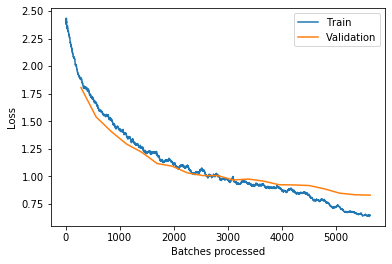

In [ ]:
learn.recorder.plot_losses()

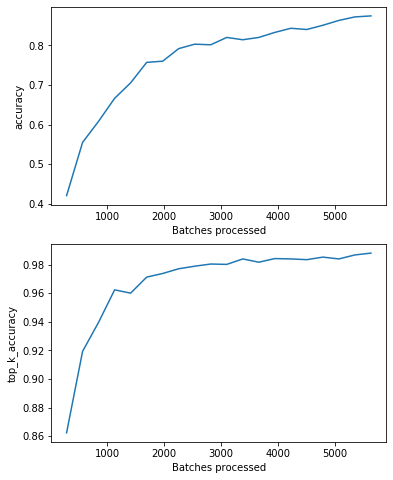

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.896176,1.813364,0.403665,0.882413,01:42
1,1.637129,1.501441,0.562230,0.925681,01:42
2,1.487206,1.374828,0.637567,0.942988,01:42
3,1.325561,1.275634,0.680071,0.965131,01:42
4,1.279334,1.178288,0.730720,0.966404,01:42
5,1.156329,1.130305,0.747264,0.970985,01:43
6,1.125668,1.066135,0.777806,0.974294,01:42
7,1.074676,1.024929,0.793841,0.975312,01:42
8,1.031411,1.005246,0.809366,0.977348,01:42
9,0.990445,1.005894,0.797404,0.973021,01:42


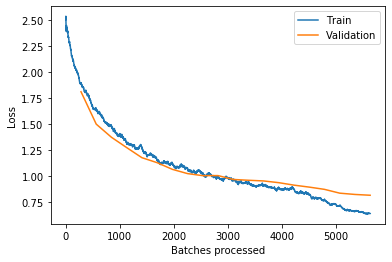

In [ ]:
learn.recorder.plot_losses()

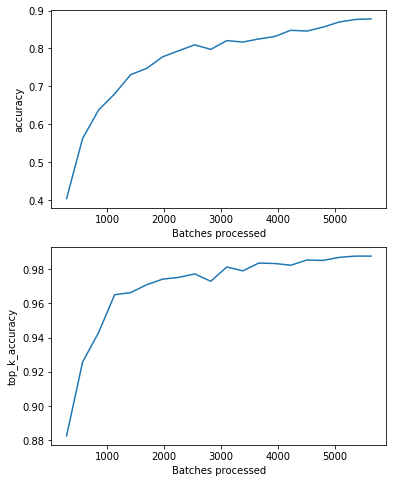

In [ ]:
learn.recorder.plot_metrics()


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.879772,1.862322,0.410537,0.866887,01:42
1,1.644690,1.669008,0.517180,0.923136,01:42
2,1.456890,1.331606,0.652838,0.955968,01:42
3,1.331498,1.240978,0.698906,0.963095,01:42
4,1.251138,1.175720,0.722576,0.963349,01:43
5,1.168022,1.113267,0.756681,0.970221,01:43
6,1.128489,1.092905,0.764062,0.974294,01:43
7,1.071325,1.053600,0.784678,0.976330,01:42
8,1.038296,0.981178,0.813184,0.979639,01:42
9,1.007002,0.998843,0.801222,0.976839,01:42


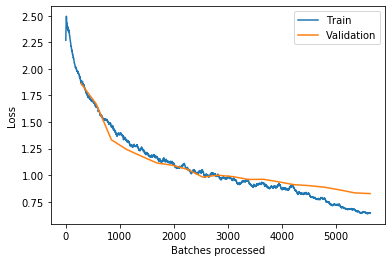

In [ ]:
learn.recorder.plot_losses()

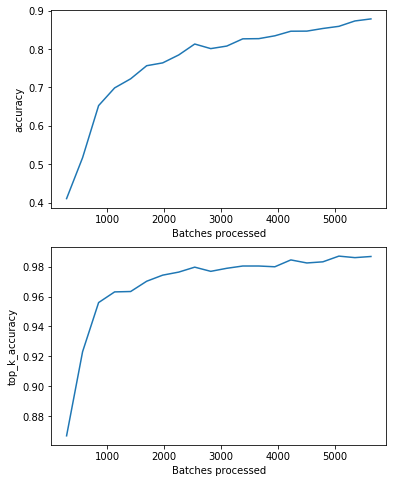

In [ ]:
learn.recorder.plot_metrics()


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.866132,1.743006,0.431662,0.885213,01:42
1,1.649543,1.669000,0.515907,0.923390,01:42
2,1.487756,1.390319,0.618733,0.945024,01:42
3,1.333780,1.234973,0.705523,0.962840,01:42
4,1.263016,1.185292,0.721303,0.963095,01:42
5,1.180126,1.108759,0.762026,0.973021,01:42
6,1.127670,1.084044,0.769661,0.969203,01:42
7,1.057895,1.055403,0.777043,0.978366,01:43
8,1.027599,1.033200,0.791041,0.978621,01:42
9,0.998072,1.009715,0.799186,0.975821,01:42


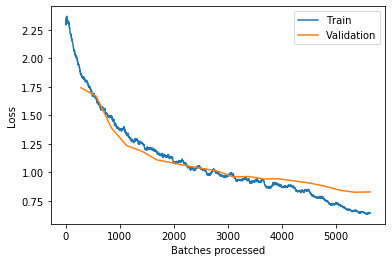

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.930055,1.766917,0.418682,0.897684,01:42
1,1.665640,1.573439,0.517944,0.925426,01:42
2,1.512747,1.486168,0.573174,0.945279,01:42
3,1.344106,1.222671,0.708832,0.963858,01:42
4,1.272199,1.181986,0.716467,0.972258,01:43
5,1.198307,1.120823,0.742937,0.970476,01:43
6,1.103335,1.085347,0.766098,0.974803,01:43
7,1.097747,1.055618,0.777806,0.977093,01:42
8,1.057409,1.020130,0.800458,0.975566,01:43
9,0.998114,0.995424,0.795113,0.982947,01:43


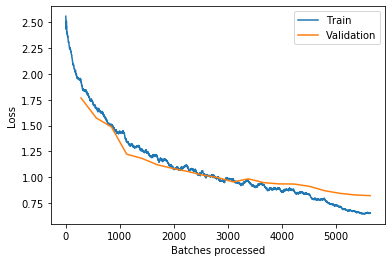

In [ ]:
learn.recorder.plot_losses()

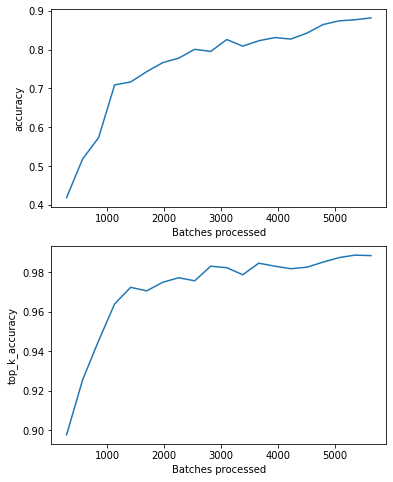

In [ ]:
learn.recorder.plot_metrics()

# e20 results

In [ ]:
acc = np.array([0.874777, 0.877832, 0.878595, 0.880377, 0.881395])

In [ ]:
acc.mean(), acc.std()

# epochs 80

In [ ]:
epochs = 80

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.843249,1.751633,0.459150,0.892848,01:42
1,1.642368,1.551752,0.530415,0.920336,01:42
2,1.472404,1.400948,0.627641,0.947060,01:42
3,1.343889,1.282823,0.682616,0.960804,01:42
4,1.259245,1.150648,0.743701,0.968694,01:42
5,1.159481,1.095263,0.770934,0.971240,01:42
6,1.151687,1.059049,0.780606,0.975821,01:42
7,1.103949,1.072602,0.772461,0.975566,01:43
8,1.057345,1.041002,0.779333,0.975312,01:42
9,0.993220,1.026004,0.788241,0.976839,01:42


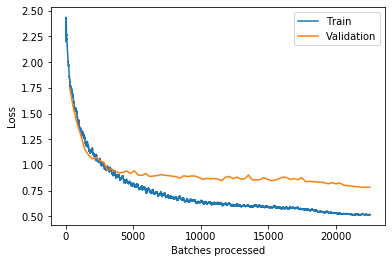

In [ ]:
learn.recorder.plot_losses()

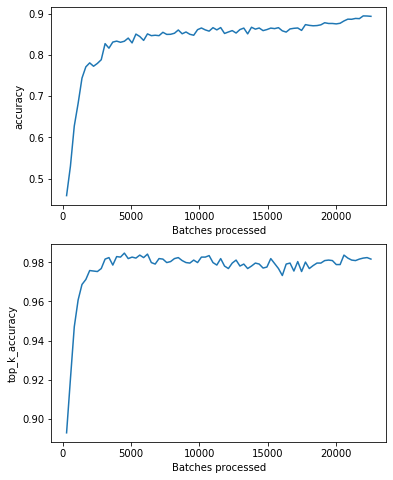

In [ ]:
learn.recorder.plot_metrics()

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.906847,1.774188,0.426826,0.881395,01:42
1,1.687434,1.571999,0.528379,0.918809,01:43
2,1.507506,1.423348,0.609570,0.945788,01:42
3,1.361088,1.296032,0.664546,0.959532,01:42
4,1.248759,1.159949,0.733520,0.966404,01:42
5,1.187731,1.106255,0.753881,0.970985,01:42
6,1.129111,1.087642,0.764062,0.971494,01:43
7,1.087413,1.047732,0.788496,0.976584,01:42
8,1.057602,1.024335,0.789768,0.977857,01:42
9,1.000485,0.984618,0.811148,0.977093,01:42


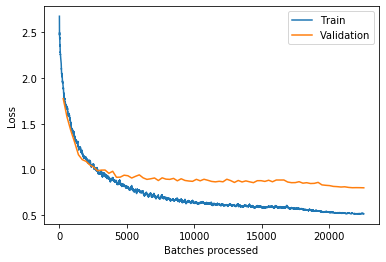

In [ ]:
learn.recorder.plot_losses()

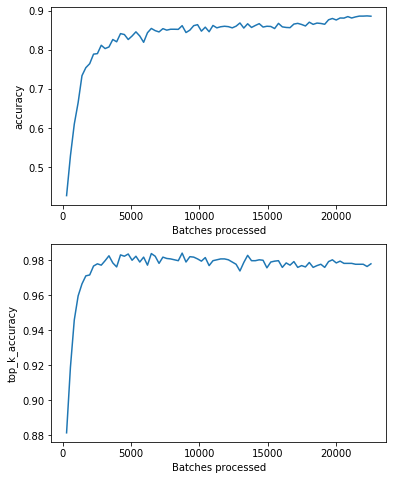

In [ ]:
learn.recorder.plot_metrics()


# e80 results

In [ ]:
acc = np.array([0.893357, 0.885467])

In [ ]:
acc.mean(), acc.std()


(0.889412, 0.003944999999999976)

## epochs 80, mixup 0.2

In [ ]:
mixup=0.02

In [ ]:
learn = get_learn(model=model,size=size,bs=bs,mixup=mixup)
learn.fit_fc(epochs, lr, moms,start_pct)

data path   /notebooks/data/imagewoof2
Learn path /notebooks/data/imagewoof2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.892982,1.760529,0.438789,0.888012,01:42
1,1.696311,1.541137,0.543650,0.926953,01:43
2,1.536865,1.524288,0.577755,0.931789,01:43
3,1.415962,1.246328,0.694070,0.964113,01:42
4,1.302436,1.186402,0.729193,0.966658,01:43
5,1.242331,1.138957,0.739628,0.969967,01:42
6,1.172702,1.090300,0.758463,0.972003,01:42
7,1.126768,1.040274,0.786460,0.974803,01:43
8,1.099874,1.048717,0.782387,0.971494,01:43
9,1.031331,0.999306,0.798676,0.980402,01:42


In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()


In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn = get_learn(model=model,size=size,bs=bs)
learn.fit_fc(epochs, lr, moms,start_pct)

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.recorder.plot_metrics()